# COGS 108 - Final Project

## Important

- ONE, and only one, member of your group should upload this notebook to TritonED. 
- Each member of the group will receive the same grade on this assignment. 
- Keep the file name the same: submit the file 'FinalProject.ipynb'.
- Only upload the .ipynb file to TED, do not upload any associted data. Make sure that for cells in which you want graders to see output that these cells have been executed.

## Group Members: Fill in the Student IDs of each group member here

Replace the lines below to list each persons full student ID, ucsd email and full name.

-  
- 
- 
- 



# Part 0 - Importing the required packages

In [1]:
import pandas as pd # for use of dataframes
import numpy as np
import matplotlib.pyplot as plt # for plotting graphs 
import statsmodels.api as sm # for fitting an OLS model
import scipy.stats as stats # for access to tests for normal distribution
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind, normaltest # for access to t tests, normal test
%matplotlib inline

# Part 1 - Introduction and Background

Chicago, otherwise known as 'The Windy City', has some of the worst crime rates in America. Some of this has to do with statitical flukes; it is the third largest city in the U.S., which makes any type of criminal activity more easily reportable. However, most people wouldn't argue over the real danger you are in when you go to some of the worse off areas of Chicago.

We wanted to analyze the crime rates in Chicago in some way in order to assist people in the city in understanding what problems exist and where they are happening. In the end, we decided to ask the following question:

"Does the district a crime is committed in or type of crime more closely predict whether an arrest was made".

The answers derived from the answer to this question could spawn further analysis, e.g.:

1. If a particular crime is more likely to result in an arrest in one district over the other, why is that? Is it the police in that district? Is it the citizens? Or is it the geography?

2. If the type of crime affects whether an arrest is made, does that mean that we are more afraid of certain crimes over others? Is this a valid fear? 

# Part 2 - Data Description

We are using this dataset: https://www.kaggle.com/chicago/chicago-crime

This is chicago crime data from 2001 to present. It represents all reported instances of crime, and whether or not an arrest has been made since the data was last released. Each row represents a crime, except for multiple homicides, for which there is a different row for each victim of the crime. 

Here are some basic stats:

In [2]:
crime = pd.read_csv('/Users/alvin/Downloads/Crimes_-_2001_to_present.csv')

In [3]:
crime.describe()

,ID,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
count,6.808630e+05,680863.000000,680863.000000,676588.000000,676455.000000,6.776110e+05,6.776110e+05,680863.000000,677611.000000,677611.000000
mean,8.567042e+06,1175.978743,11.308450,22.770445,37.770586,1.164485e+06,1.885306e+06,2011.814654,41.840877,-87.671938
std,8.225777e+05,698.030896,6.916479,13.753105,21.547608,1.653952e+04,3.170872e+04,1.349423,0.087219,0.060123
min,2.755000e+03,111.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,2001.000000,36.619446,-91.686566
25%,8.217138e+06,621.000000,6.000000,10.000000,23.000000,1.152671e+06,1.858662e+06,2011.000000,41.767524,-87.714810
50%,8.750056e+06,1031.000000,10.000000,22.000000,32.000000,1.165933e+06,1.890256e+06,2012.000000,41.854636,-87.666379
75%,9.032286e+06,1723.000000,17.000000,34.000000,58.000000,1.176352e+06,1.909012e+06,2013.000000,41.906133,-87.628220
max,1.050916e+07,2535.000000,31.000000,50.000000,77.000000,1.205119e+06,1.951573e+06,2016.000000,42.022710,-87.524529


In [4]:
print('Total Number of Crimes:\t\t\t{0}'.format(len(crime)))
print('Total number of Unique Districts:\t{0}'.format(len(crime['District'].unique())))

Total Number of Crimes:			680863
Total number of Unique Districts:	23


# Part 3 - Data Cleaning and Preprocessing

This data is fairly clean, because it is maintained by the Chicago Police Department, which has high organizational standards. There aren't very many invalid crimes or unknowns.

To clean the data, we will do the following (not necessarily in order):

1. Drop useless columns and columns that invade privacy
2. Standardize the location description
3. Standardize the crime type to get rid of the uppercase, standardize the non-criminal type
4. Remove NaN values

In [5]:
# first, drop the location description column and community area column because of privacy concerns 
crime = crime.drop(['Location Description', 'Block', 'Community Area','Latitude', 'Beat', 'Ward','Longitude','X Coordinate','Y Coordinate','Location','Ward'],axis=1)

In [6]:
"""
    Author: James McDougall
    Param: string - is the string which is the name of the Primary Type
    Returns: a variable of type str which is lower case and represents  a more standardized type
"""
def standardize_primary_type(string):
    # compile all non-criminal offenses into on label
    if string == 'NON-CRIMINAL (SUBJECT SPECIFIED)' or string == 'NON - CRIMINAL' or string == 'NON-CRIMINAL':
        return 'non-criminal'
    if string == 'OTHER OFFENSE':
        return 'other'
    # rename crim sexual assault to just sexual assault to make it easier to read
    if string == 'CRIM SEXUAL ASSAULT':
        return 'sexual assault'
    else:
        # everything else, make sure to lowercase it so we don't have to use caps lock lol
        return string.lower()
        

In [7]:
to_drop = crime[ crime['District'].isnull()]
print('Number of rows to drop with NaN district: ' + str(len(to_drop)))
crime = crime.drop(to_drop.index,axis=0)

to_drop = crime[crime['Primary Type'].isnull()]
print('Number of row to drop with NaN Primary Type: ' + str(len(to_drop)))
crime = crime.drop(to_drop.index,axis=0)

Number of rows to drop with NaN district: 0
Number of row to drop with NaN Primary Type: 0


In [8]:
crime['Type'] = crime['Primary Type'].apply(standardize_primary_type)
crime['District'] = crime['District'].astype(str)

def arrest_to_int(string):
    if string == True:
        return 1
    elif string == False:
        return 0
crime['Arrest'] = crime['Arrest'].apply(arrest_to_int)


Additionally, we must drop all rows that are in district 31 because this district is not on the main chicago police page, so it is either nonexistant or far enough away from the main Chicago city to not be relevant to our analysis.

In [9]:
crime = crime[crime['District'] != '31']
assert '31' not in crime['District'].unique()

# Part 4 - Data Visualization

First, let's take a look at the data that we have immediately at our hands by seeing the graph of how many of each type of crimes have been reported to and documented by the Chicago Police Department. 

<BarContainer object of 29 artists>

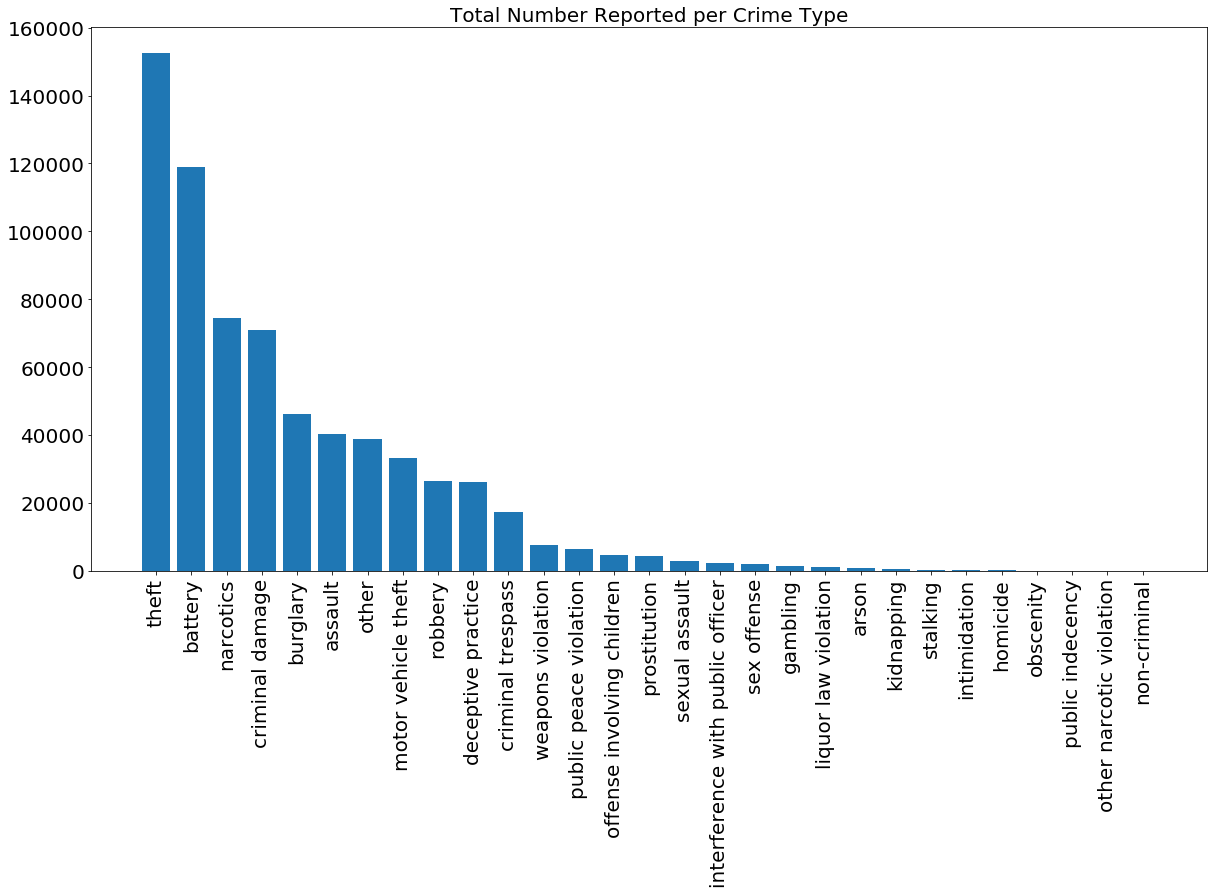

In [10]:
plt.figure(figsize=(20,10))
crimeType = plt.bar(crime.Type.value_counts().index, crime.Type.value_counts())
plt.title('Total Number Reported per Crime Type', fontsize='20')
plt.xticks(rotation='vertical')
plt.tick_params(labelsize=20)
crimeType

From the above graph, we can see that certain crime types are reported and/or occur much more frequently than others (the top 3 being theft, battery, and narcotics). Now that we can see which crimes are reported the most, let's dive deeper and see how many total crimes are reported in each district.

In [11]:
districts = crime['District'].unique()
district_cache = {}
arrest_cache = {}
ratio_cache = {}
for district in districts:
    district_cache[district] = len(crime[ crime['District'] == district ]) #gets total num of crimes in each district
    arrest_cache[district] = len(crime[ (crime['Arrest'] == True) & (crime['District'] == district)]) #gets total num of arrests per district
    ratio_cache[district] = arrest_cache[district] / district_cache[district] #gets the ratio of arrests per crime in each district 
print(district_cache)
print(arrest_cache)
print(ratio_cache)

{'10': 30448, '9': 34569, '18': 28690, '5': 30903, '16': 22599, '19': 31026, '2': 28421, '17': 19713, '1': 24813, '15': 30056, '8': 46880, '22': 22328, '6': 39996, '14': 25030, '12': 32439, '7': 41014, '3': 35816, '11': 44801, '25': 40388, '4': 40354, '20': 11035, '24': 19526}
{'10': 9997, '9': 10091, '18': 7085, '5': 8751, '16': 4167, '19': 6565, '2': 7217, '17': 4131, '1': 6948, '15': 12363, '8': 12210, '22': 5022, '6': 11883, '14': 4825, '12': 7310, '7': 12493, '3': 9471, '11': 19279, '25': 11573, '4': 9463, '20': 2670, '24': 4951}
{'10': 0.32833026799789805, '9': 0.29190893575168503, '18': 0.24695015684907634, '5': 0.28317639064168526, '16': 0.18438868976503386, '19': 0.21159672532714496, '2': 0.25393195172583655, '17': 0.20955714503119768, '1': 0.2800145085237577, '15': 0.41133217993079585, '8': 0.26045221843003413, '22': 0.22491938373342887, '6': 0.2971047104710471, '14': 0.19276867758689573, '12': 0.22534603409476248, '7': 0.30460330618813086, '3': 0.2644348894348894, '11': 0.43

In [12]:
districtsTotalCrime = pd.DataFrame.from_dict(district_cache, orient='index')
districtsTotalCrime.columns = ['Total Crimes Reported']
districtsTotalCrime.index.name = 'District Number'
districtsTotalCrime.head()

,Total Crimes Reported
District Number,
10,30448
9,34569
18,28690
5,30903
16,22599


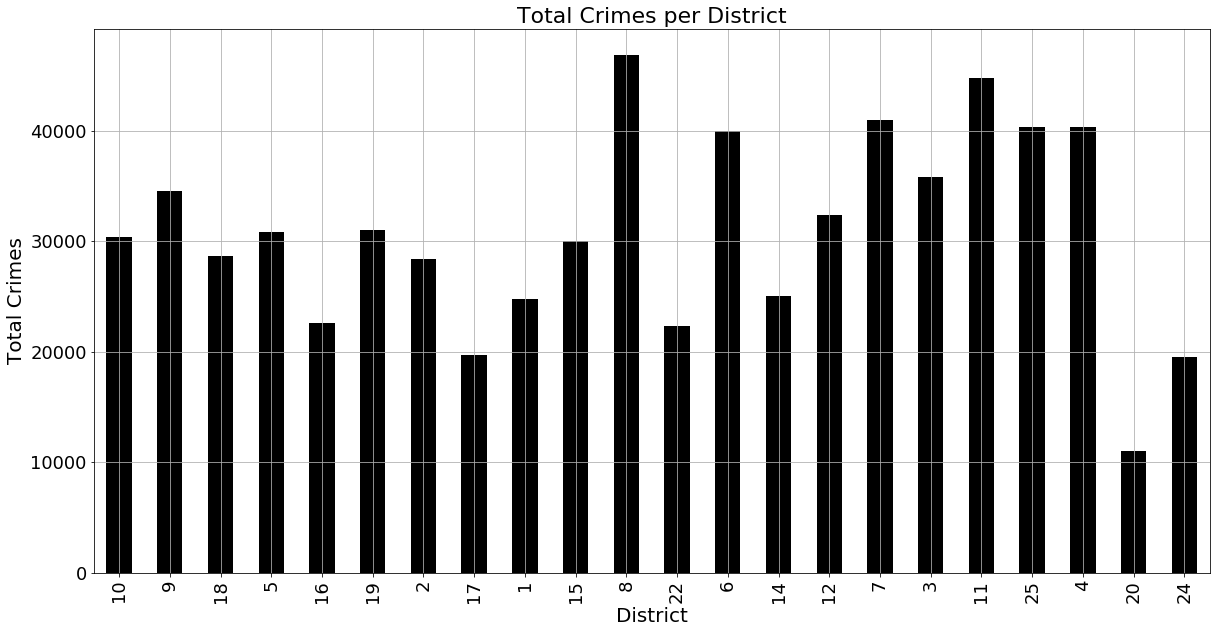

In [13]:
DTCchart = districtsTotalCrime.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color='k')
DTCchart.set_title('Total Crimes per District', fontsize=22)
DTCchart.set_xlabel('District', fontsize=20)
DTCchart.set_ylabel('Total Crimes', fontsize=20)
DTCchart.tick_params(labelsize=18)
DTCchart

From the bar chart above, we can see that Districts 8 and 3 have the highest number of crime reports while districts 20 and 24 have the least. But our research question revolves around arrests so let's get a graph with the ratios of arrests per crime report in each district. Therefore, we would actually be able to see and compare the percentage of crimes that lead to an arrest because while a district might have more crimes, they might not have as many arrests as another district with less crime reports.  

In [14]:
districtsRatio = pd.DataFrame.from_dict(ratio_cache, orient='index')
districtsRatio.columns = ['Arrest to Crime Ratio']
districtsRatio.index.name = 'District Number'
districtsRatio.head()

,Arrest to Crime Ratio
District Number,
10,0.328330
9,0.291909
18,0.246950
5,0.283176
16,0.184389


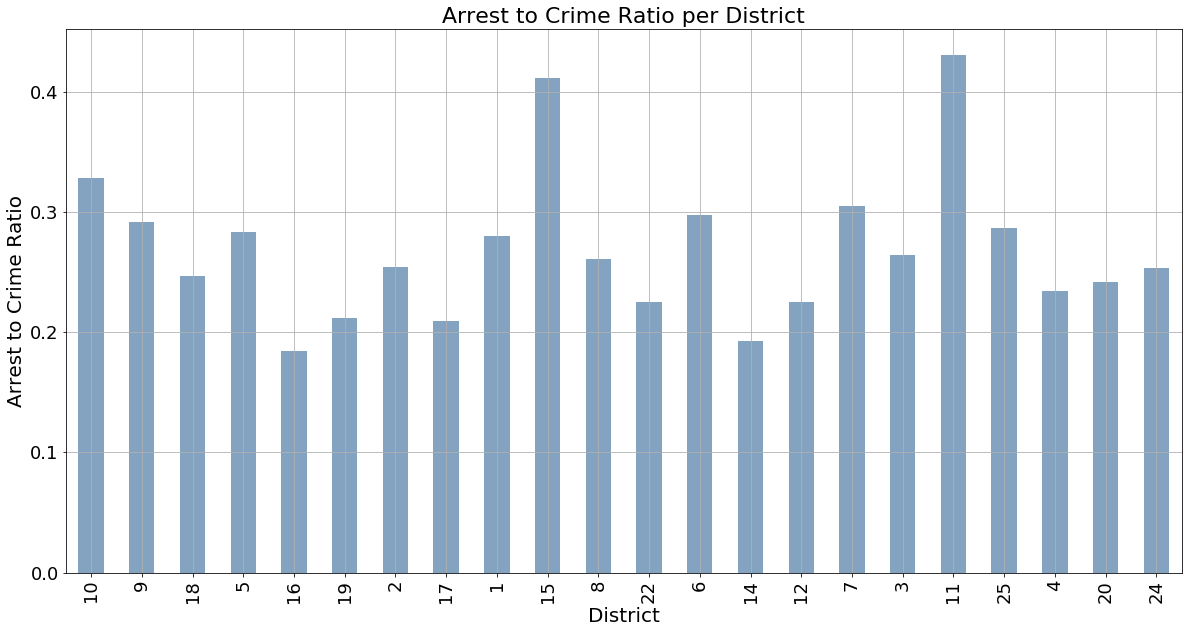

In [15]:
ratioChart = districtsRatio.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color=(0.2, 0.4, 0.6, 0.6))
ratioChart.set_title('Arrest to Crime Ratio per District', fontsize=22)
ratioChart.set_xlabel('District', fontsize=20)
ratioChart.set_ylabel('Arrest to Crime Ratio', fontsize=20)
ratioChart.tick_params(labelsize=18)
ratioChart

As we suspected, this bar graph shows that the highest crime reported districts are different from the the highest arrest ratio districts. For example, we can see that the two districts with the highest arrest to crime ratio are Districts 15 and 11 while the two districts with the highest reported crimes (shown in the previous graph) were Districts 8 and 3.

With this new found info, let's finish out our Data Visualization section by focusing in on the top 3 Crime types (Theft, Battery, and Narcotics) and ploting their arrest to report ratio in each district to compare and utilize in our later Data Analysis section. 

To do this, we basically got the number of reports for each crime, the number of arrests made for each crime, and divided the number of arrests over the number of reports to get the final ratio. We ended up doing this for each district, which allowed us to create 3 separate bar graphs to visualize our data.

In [16]:
crime['Primary Type'].value_counts().nlargest(3)

THEFT        152481
BATTERY      118891
NARCOTICS     74629
Name: Primary Type, dtype: int64

In [17]:
dist_pred_arrest = pd.DataFrame()
for district in districts:
    arrest_occurred = crime[crime['Arrest'] == True]   
    
    dist_pred_arrest.loc[district, 'Reported Theft'] = len(crime[(crime['Primary Type'] == 'THEFT') & (crime['District'] == district)]) 
    dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] = len(arrest_occurred[(arrest_occurred['Primary Type'] == 'THEFT') & (arrest_occurred['District'] == district)])
    dist_pred_arrest.loc[district,'Theft Arrest Rate'] = dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Theft']
    
    dist_pred_arrest.loc[district, 'Reported Battery'] = len(crime[(crime['Primary Type'] == 'BATTERY') & (crime['District'] == district)]) 
    dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] = len(arrest_occurred[(arrest_occurred['Primary Type'] == 'BATTERY') & (arrest_occurred['District'] == district)])
    dist_pred_arrest.loc[district,'Battery Arrest Rate'] = dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Battery']
    
    dist_pred_arrest.loc[district, 'Reported Narcotics'] = len(crime[(crime['Primary Type'] == 'NARCOTICS') & (crime['District'] == district)]) 
    dist_pred_arrest.loc[district,'Narcotics w/ Arrest Made'] = len(arrest_occurred[(arrest_occurred['Primary Type'] == 'NARCOTICS') & (arrest_occurred['District'] == district)])
    dist_pred_arrest.loc[district,'Narcotics Arrest Rate'] = dist_pred_arrest.loc[district,'Narcotics w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Narcotics']
print(dist_pred_arrest)

    Reported Theft  Theft w/ Arrest Made  Theft Arrest Rate  Reported Battery  \
10          4782.0                 406.0           0.084902            6443.0   
9           6340.0                 676.0           0.106625            6295.0   
18         13534.0                1893.0           0.139870            3094.0   
5           4630.0                 272.0           0.058747            6550.0   
16          5507.0                 370.0           0.067187            3105.0   
19         11211.0                 982.0           0.087593            3753.0   
2           6326.0                 535.0           0.084572            5377.0   
17          4737.0                 629.0           0.132784            3143.0   
1          11846.0                2055.0           0.173476            2296.0   
15          3821.0                 233.0           0.060979            6100.0   
8           9745.0                1369.0           0.140482            7392.0   
22          4792.0          

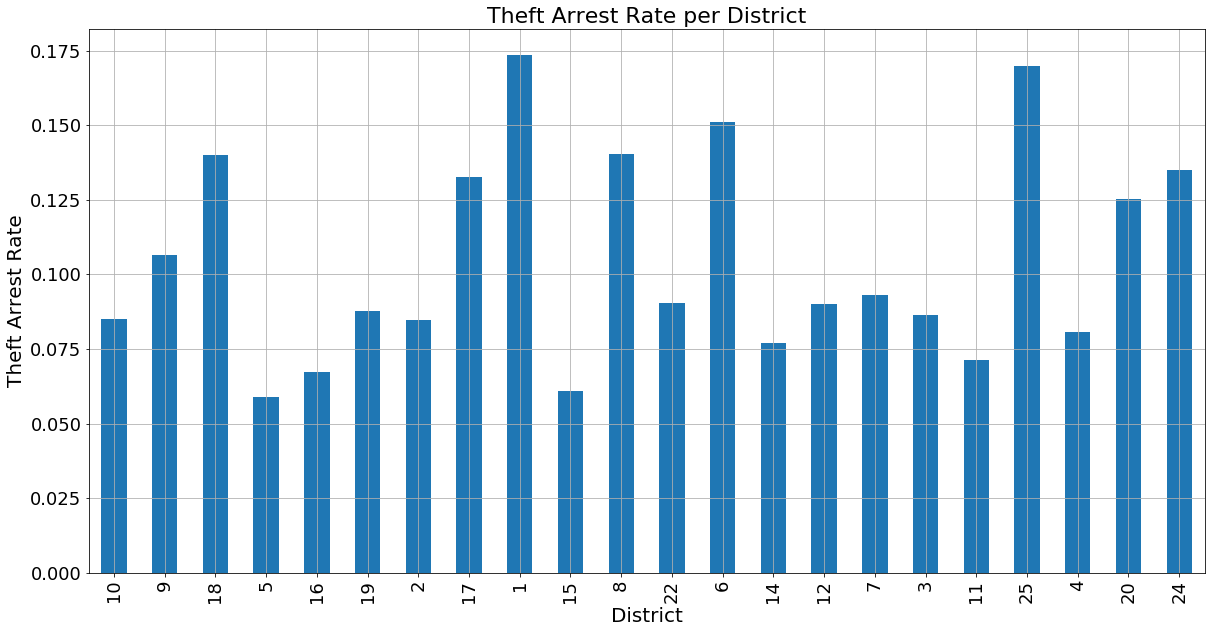

In [18]:
thefts = dist_pred_arrest['Theft Arrest Rate'] 
theftRate = thefts.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color='tab:blue') 
theftRate.set_title('Theft Arrest Rate per District', fontsize=22)
theftRate.set_xlabel('District', fontsize=20)
theftRate.set_ylabel('Theft Arrest Rate', fontsize=20)
theftRate.tick_params(labelsize=18)
theftRate

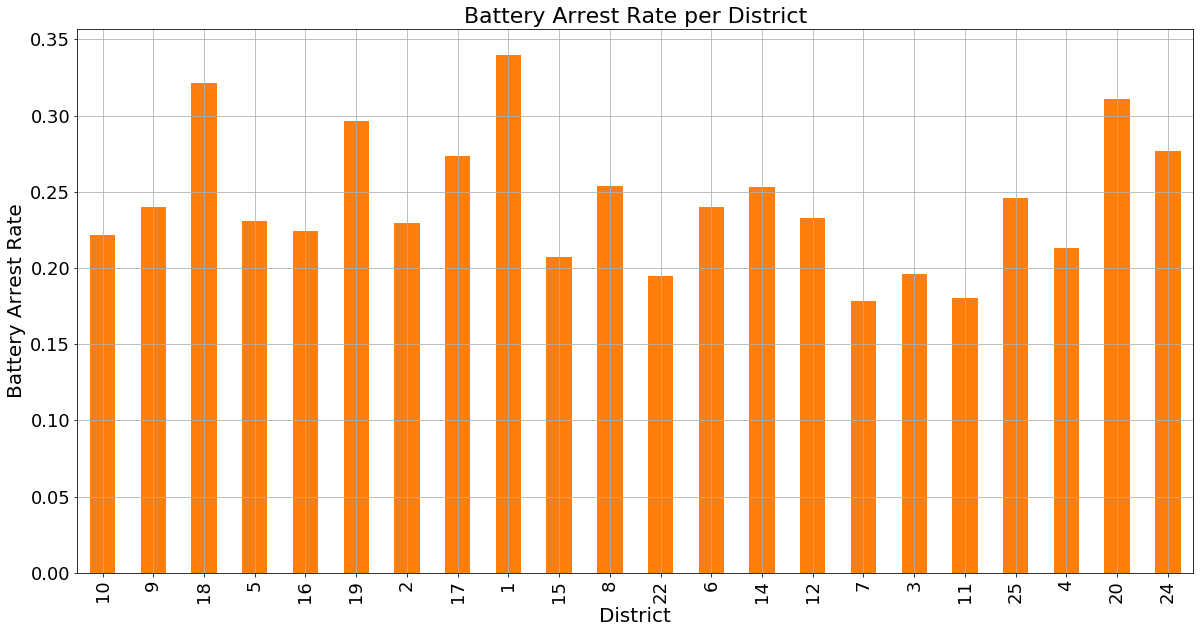

In [19]:
battery = dist_pred_arrest['Battery Arrest Rate'] 
batteryRate = battery.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color='tab:orange') 
batteryRate.set_title('Battery Arrest Rate per District', fontsize=22)
batteryRate.set_xlabel('District', fontsize=20)
batteryRate.set_ylabel('Battery Arrest Rate', fontsize=20)
batteryRate.tick_params(labelsize=18)
batteryRate

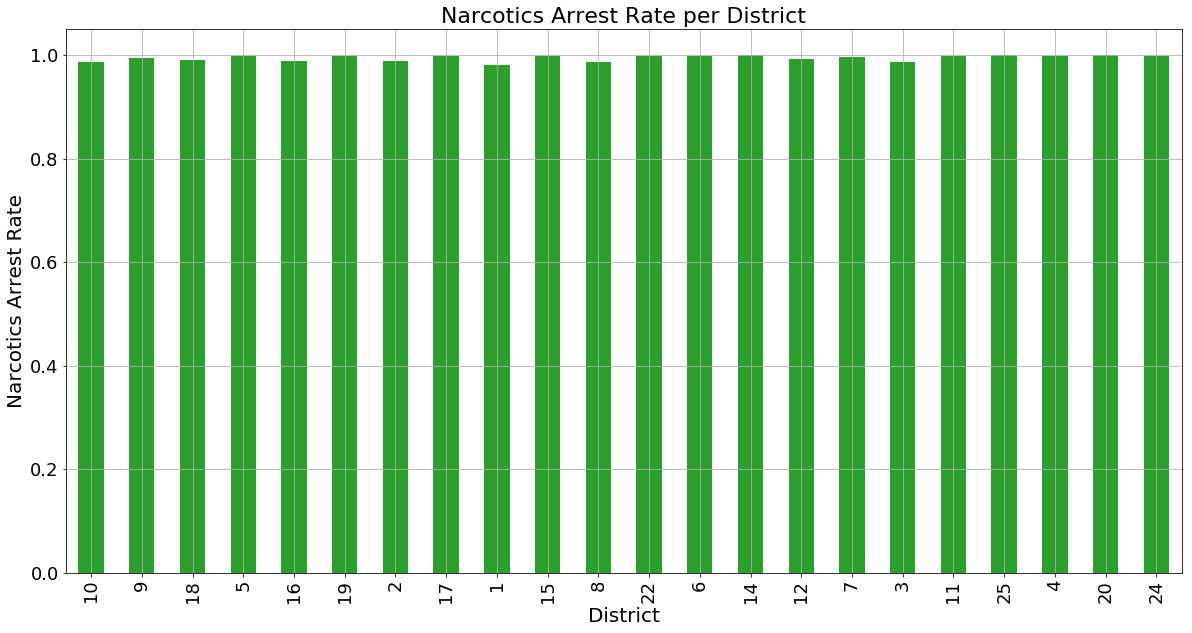

In [21]:
narcotics = dist_pred_arrest['Narcotics Arrest Rate'] 
narcoticsRate = narcotics.plot(kind='bar', grid=True, figsize=(20,10), legend=False, color='tab:green') 
narcoticsRate.set_title('Narcotics Arrest Rate per District', fontsize=22)
narcoticsRate.set_xlabel('District', fontsize=20)
narcoticsRate.set_ylabel('Narcotics Arrest Rate', fontsize=20)
narcoticsRate.tick_params(labelsize=18)
narcoticsRate

From these three graphs, we can see how Theft anad Battery arrest ratios vary from district to district, while Narcotics arrest ratios seem to be fairly across the districts. Let's now jump into using this data to build a model and come up with an analysis that answers our research question.

# Part 5 - Data Analysis and Results

Our research questions is whether an arrest was made from a reported crime is better predicted by the type of crime commmited or the district the crime is committed.

Because the dependent variable, Arrest is a true or false value, we first converted it to a 1 or a 0, with 1 for true and 0 for false.

Because Arrest is binary, we chose a Binomial regression as our data model. Binomial regression/Logistic regression is useful when a dependent variable is binary because it doesn't attempt to fit a line to the data, it produces a curve that represents the chance that an input would results in a true or a false value.

In [ ]:
binomial_model = smf.glm(formula='Arrest ~ Type + District', data=crime,family=sm.families.Binomial())
binomial_results = binomial_model.fit()
binomial_results.summary()

## Preliminary Analysis

The intercept of the model is an arson committed in district 1. We found this out by noticing that district 1 is the only district not included in the summary, and arson is the only crime type not included in the summary. 

The coefficient of the intercept is -1.5564. All other coefficients can be interpreted in terms of the intercept coefficient:

Case 1: Coefficient of a variable is less than -1.5564. That implies that this variable is less predictive of whether an arrest was made than an arson committed in district 1.

Case 2: Coefficient of a variable is greater than -1.5564. This implies that the variable is more predictive of whether an arrest was made than an arson committed in district 1. For example, assault has a coefficient of 0.9820, which is higher than the intercept. This means that the type of crime 'assault' is more predictive of whether you will be arrested for a crime than an arson in district 1. If you then add the coefficients from assault and district 1, you get 

In addition, we have to take the p-values into account. A small p-value indicates that a variable is not very influential. We use the standard alpha of 0.05 as our p-value signifance test. If a p-value is less than 0.05, we consider the associated variable to be significant. If it is greater than 0.05 we consider it to not be significant.

We find that almost all the p-values are significant, which means most of the variables are significant predictors of the dependent variable, whether an arrest was made.

## Looking at the top three crimes

We want to look at the top three crimes overall, because this might give us a more generalized picture of what overall crime looks like in Chicago

In [ ]:
crime['Type'].value_counts().nlargest(3)

In [ ]:
top_crime = crime[(crime['Type'] == 'theft') | (crime['Type'] == 'battery') | (crime['Type'] == 'narcotics')]

In [ ]:
binomial_model = smf.glm(formula='Arrest ~ Type + District', data=top_crime,family=sm.families.Binomial())
binomial_results = binomial_model.fit()
binomial_results.summary()

# Part 6 - Privacy/Ethics Considerations

##### Privacy
For the purpose of our analysis, we do have permission to use this dataset becauset the police department released as public record. The data is also fairly private because there is no individual person identifying information. There are no names, only crime ids and description. The only identifying information is the location (partial addresses and longitude/latitude). This could be an issue because some of the crimes occurred in apartments, so you could conceivably find out the location where a crime was committed and use this to find someone. However, for our project purposes, we decided to use district # instead so we simply dropped those other location identifying sections from our data to further perserve the privacy of those involved when we release our findings.

##### Ethics
A potential ethics considerations involving this data is that we are publicizing the locations of high crime, which could be used to discriminate against communities. While this data is publicily available, we are organizing and formatting it in a way that can be used to show which districts have a high crime rate. People with ill intentions could use this to argue that no one should go near these areas, alientating those communities. 

# Part 7 - Conclusions and Discussion

##### Potential Biases
We realize that there are some potential biases in our dataset, because while this data was collected by the police department, there are a lot of crimes that happen where those involved do not go to or report to the police. Unfortunately these instances/crimes would be omitted from the data, which could skew the data to lean towards one or more areas unfairly.